# 0.0 Libraries

In [74]:
import pandas as pd
import inflection
import math
import calendar
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# 1.0 Data

## 1.1 Functions

## 1.2 Loading Data

In [3]:
#raw data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#joinning/merge
df_store_sales = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_store_sales.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
443666,682,5,2014-05-30,11984,1885,1,0,0,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN
1012996,247,5,2013-01-04,6812,623,1,0,0,1,d,c,70.0,11.0,2010.0,1,5.0,2013.0,"Feb,May,Aug,Nov"
573131,807,1,2014-02-03,13355,1188,1,1,0,0,a,a,3870.0,4.0,2008.0,0,NaN,NaN,NaN
659759,465,7,2013-11-17,0,0,0,0,0,0,d,c,10890.0,4.0,2005.0,0,NaN,NaN,NaN
957251,252,6,2013-02-23,8792,719,1,0,0,0,d,c,22330.0,NaN,NaN,1,5.0,2010.0,"Feb,May,Aug,Nov"


## 1.3 Data Overview

### 1.3.1 Renaming Columns

In [5]:
df1 = df_store_sales.copy()

In [6]:
cols_old = list(df_store_sales.columns)
snakecase = lambda x: inflection.underscore(x)
#new col names
cols_new = list(map(snakecase, cols_old))
cols_new

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [7]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.3.2 Data Dimensions


In [8]:
print('# of rows: {}'.format(df1.shape[0]))
print('# of columns: {}'.format(df1.shape[1]))

# of rows: 1017209
# of columns: 18


### 1.3.3 Data Types

In [9]:
# changing Date from object to date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3.4 Checking NA's

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.3.5 Filling NA's thinking about the business

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
# CompetitionDistance - no competition nearby or distance is so high we can ignore it            
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)



In [13]:
# CompetitionOpenSinceMonth - no competition or we don't know the date
# I'm using the same value as the column date to fill this NA (first iteration)    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )



In [14]:
# CompetitionOpenSinceYear     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )



In [15]:
# Promo2SinceWeek - NA = stopped promo  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)



In [16]:
# Promo2SinceYear    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [17]:
# PromoInterval - shows the months promo was active
month_map = {}
for m in range(1,13):
    month_map[m] = str(calendar.month_name[m])[0:3] 

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        

In [18]:
df1.sample(5).T

,722778,513662,799673,559466,608744
store,1044,433,1004,522,740
day_of_week,7,5,1,6,4
date,2013-09-22 00:00:00,2014-03-28 00:00:00,2013-07-15 00:00:00,2014-02-15 00:00:00,2014-01-02 00:00:00
sales,0,5716,7710,8172,4793
customers,0,627,593,646,414
open,0,1,1,1,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,c,a,d,d,d


In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.3.6 Checking data types after df manipulation

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
#promo2_since_week and year are floats and can be changed to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [22]:
#competition_since_month and year are floats and can be changed to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.3.7 Descriptive Statistics

In [24]:
#grouping columns - numerical and categorical
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.3.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skw, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenating dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() #metrics

In [26]:
m.columns = ['attributes', 'min', 'max', 'range', 'neab', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,neab,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


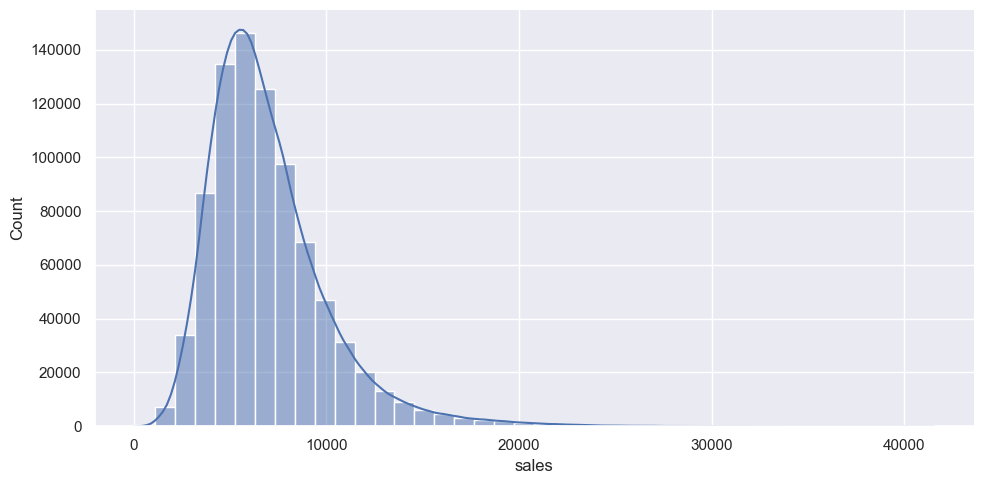

In [27]:
sns.set_theme()
df2 = df1[df1['sales']!=0]
sns.displot(df2['sales'], kde=True, height=5, aspect=2, bins=40);



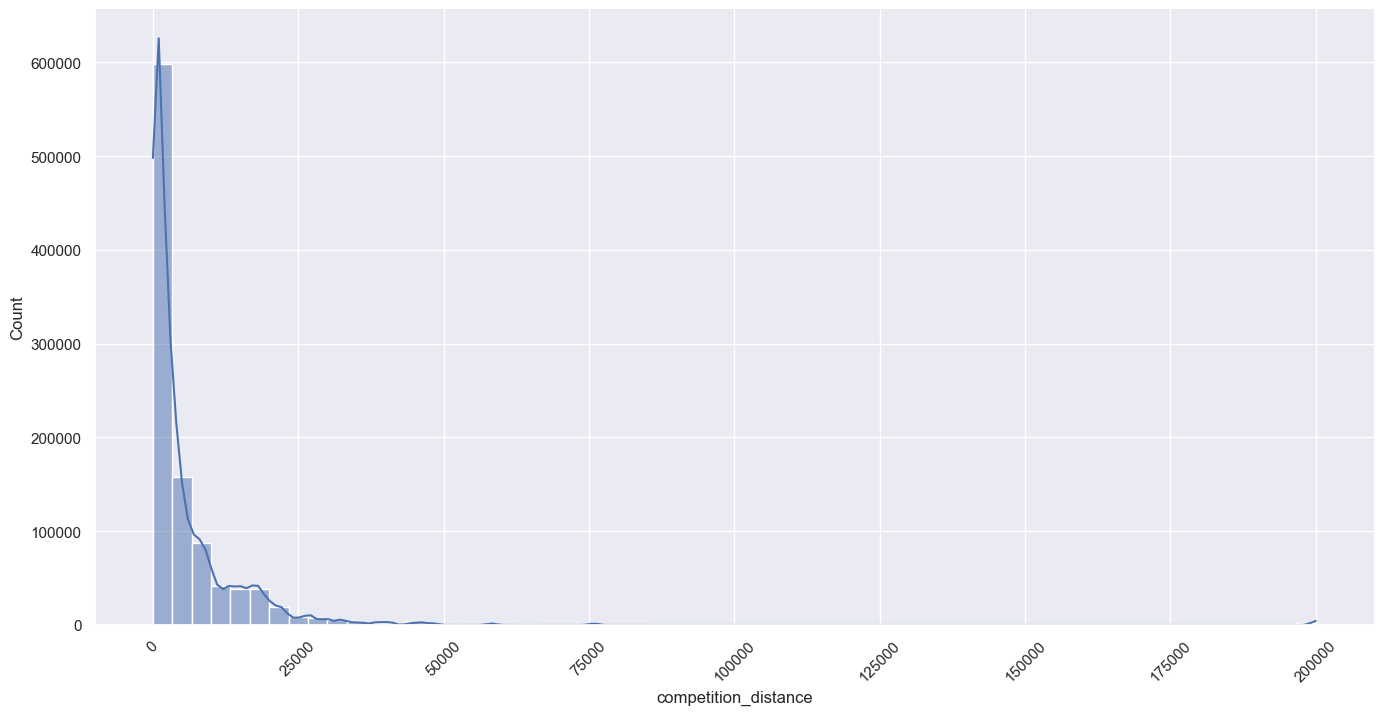

In [28]:
sns.displot(df1['competition_distance'], kde=True, bins=60, height=7, aspect=2)
plt.xticks(rotation=45);

#### 1.3.7.2 Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

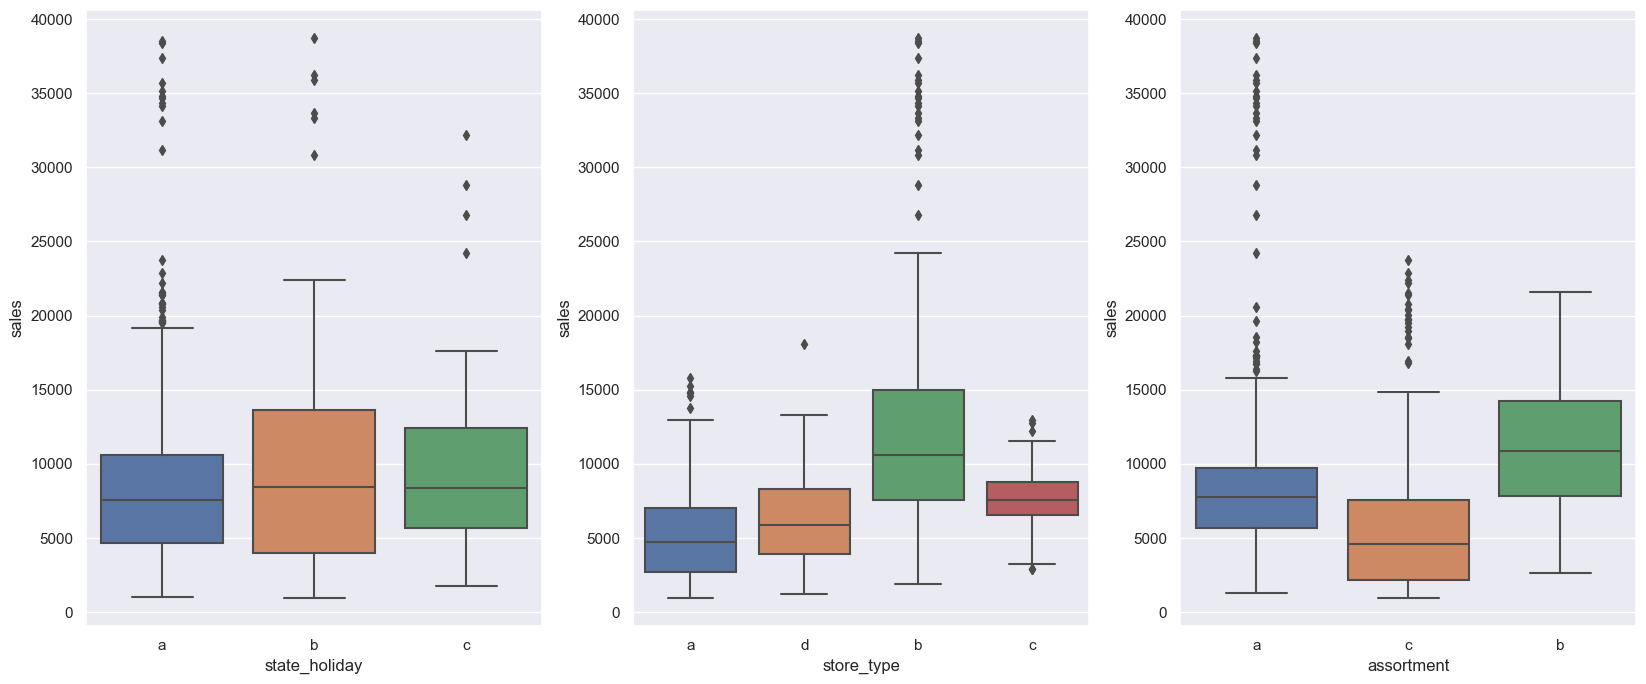

In [30]:
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.boxplot(aux1, x='state_holiday', y='sales')
plt.subplot(1,3,2)
sns.boxplot(aux1, x='store_type', y='sales')
plt.subplot(1,3,3)
sns.boxplot(aux1, x='assortment', y='sales');

# 2.0 Feature Engineering

In [31]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

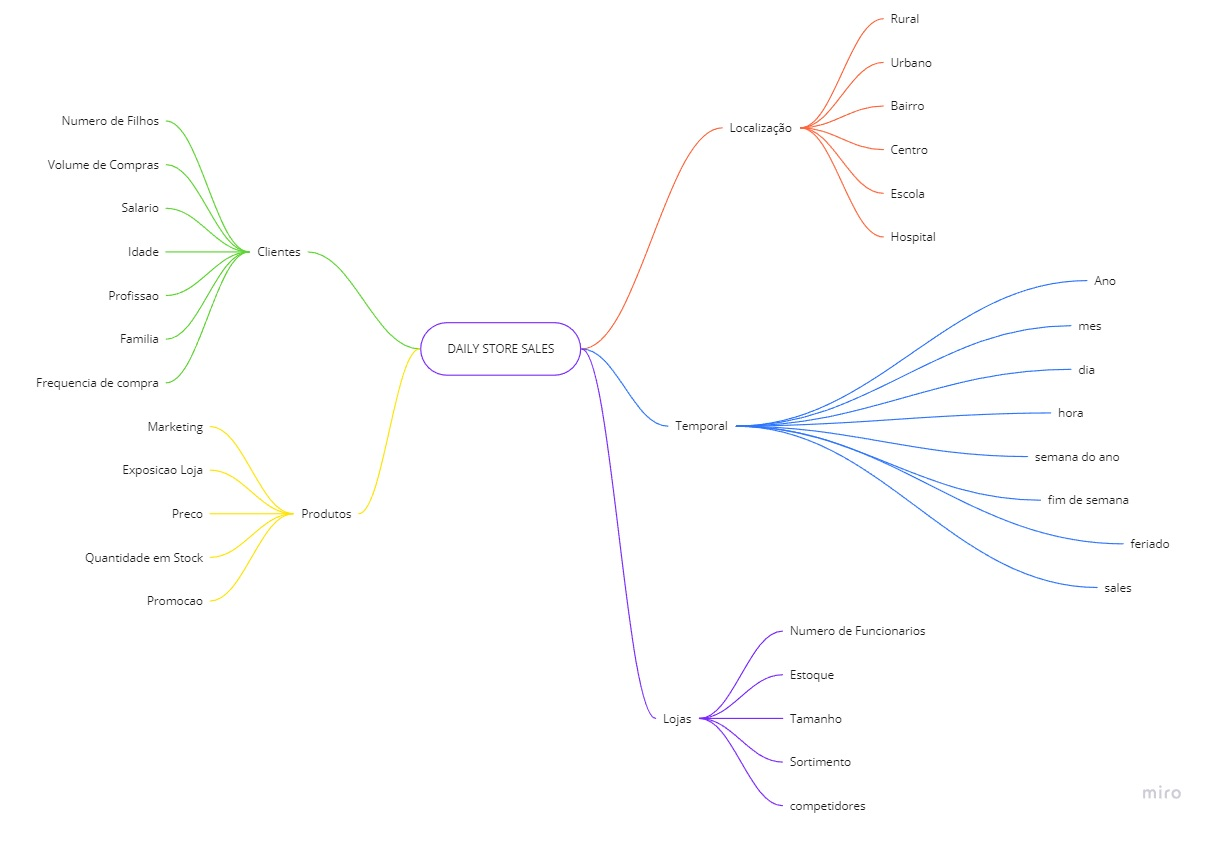

In [32]:
#mindmap coggle/miro
Image('img/mind_map.jpg')

## 2.2 Hypothesis lists

In [33]:
#hipoteses - relacionar cada atributo com a variável resposta (daily sales) para encontar uma correlação

### 2.2.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.\
**2.** Lojas com maior estoque deveriam vender mais.\
**3.** Lojas com maior porte deveriam vender mais.\
**4.** Lojas com maior sortimento deveriam vender mais.\
**5.** Lojas com competidores mais próximos deveriam vender menos.\
**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Product Hypothesis

**1.** Lojas que investem mais me marketing deveriam vender mais.\
**2.** Lojas com maior exposição dos produtos deveriam vender mais.\
**3.** Lojas que tem preços menores nos produtos deveriam vender mais.\
**4.** Lojas com promoções mais agressivas deveriam vender mais.\
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.\
**6.** Lojas com mais dias de promoção deveriam vender mais.\
**7.** Lojas com mais promoções consecutivas deveriam vender mais.\

### 2.2.3 Time Hypothesis

**1.** Lojas baertas durante o feriado de Natal deveriam vender mais.\
**2.** Lojas deveriam vender mais ao longo dos anos.\
**3.** Lojas deveriam vender mais no segundo semestre do ano.\
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.\
**5.** Lojas deveriam vender menos aos finais de semana.\
**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Hypothesis list

In [34]:
#priorizar as hipoteses que vão ser utilizadas na analise exploratoria
#escolher as hipoteses que já temos os dados primeiro

**1.** Lojas com maior sortimento deveriam vender mais.\
**2.** Lojas com competidores mais próximos deveriam vender menos.\
**3.** Lojas com competidores à mais tempo deveriam vender mais.\
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.\
**5.** Lojas com mais dias de promoção deveriam vender mais.\
**6.** Lojas com mais promoções consecutivas deveriam vender mais.\
**7.** Lojas baertas durante o feriado de Natal deveriam vender mais.\
**8.** Lojas deveriam vender mais ao longo dos anos.\
**9.** Lojas deveriam vender mais no segundo semestre do ano.\
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.\
**11.** Lojas deveriam vender menos aos finais de semana.\
**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [35]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [36]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_months'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

In [37]:
# promo since - without month and day, join week and year to get a date
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + "-1", '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_weeks'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [38]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [39]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

In [40]:
df2.sample(5).T

,170467,457913,59593,478130,706312
store,988,434,499,581,188
day_of_week,7,6,1,2,7
date,2015-03-01 00:00:00,2014-05-17 00:00:00,2015-06-08 00:00:00,2014-04-29 00:00:00,2013-10-06 00:00:00
sales,0,11305,5731,7634,0
customers,0,901,817,780,0
open,0,1,1,1,0
promo,0,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,a,c,a,d


# 3.0 Filtering Variables

In [41]:
df3 = df2.copy()

In [42]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week,year_week,competition_since,competition_time_months,promo_since,promo_time_weeks
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtering Lines

In [43]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

## 3.2 Selecting Columns

In [44]:
#ignorar coluna customers - nós não temos o valor das próximas semanas para usar nesa predição
#para isso preciso de um projeto com predição de curtomers e utilizar o resultado com input nesse

#removendo colunas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [45]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week', 'year_week', 'competition_since',
       'competition_time_months', 'promo_since', 'promo_time_weeks'],
      dtype='object')

# 4.0 EDA - Exploratory Data Analysis

In [46]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable 

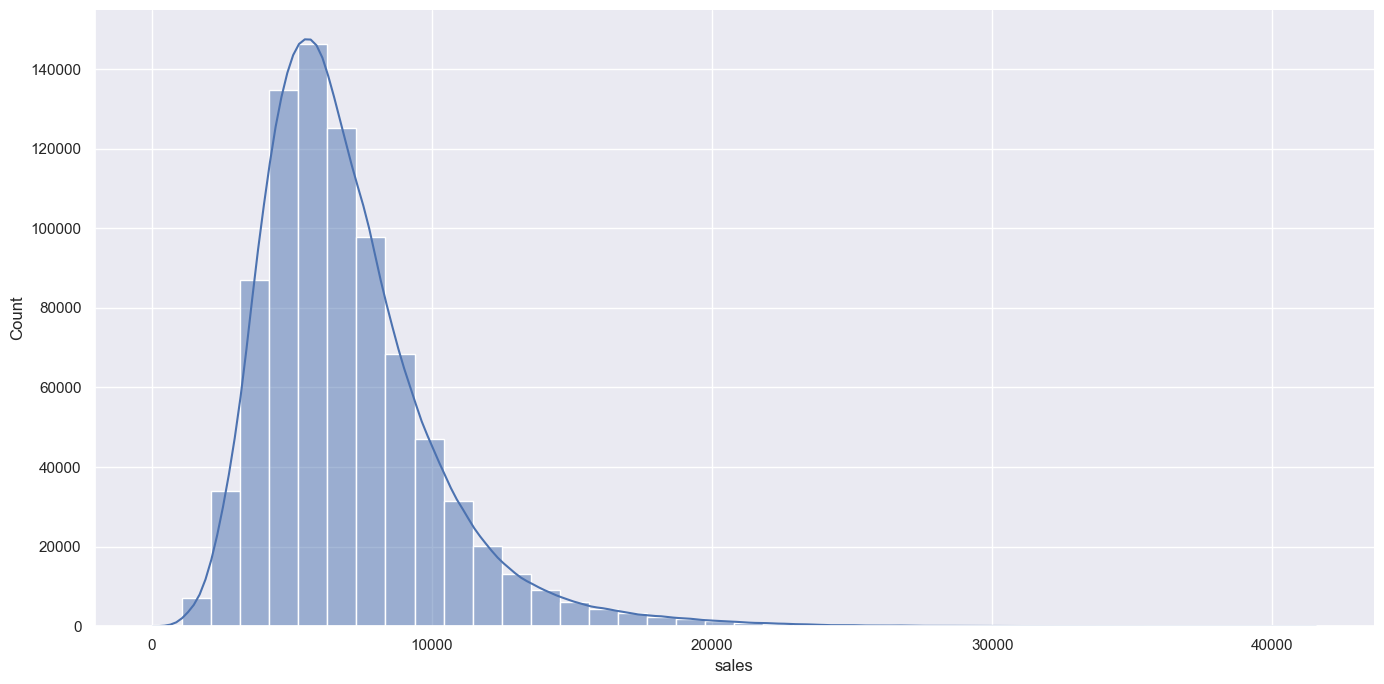

In [47]:
sns.displot(df4['sales'], bins=40, kde=True, height=7, aspect=2);

### 4.1.2 Numeric Variable 

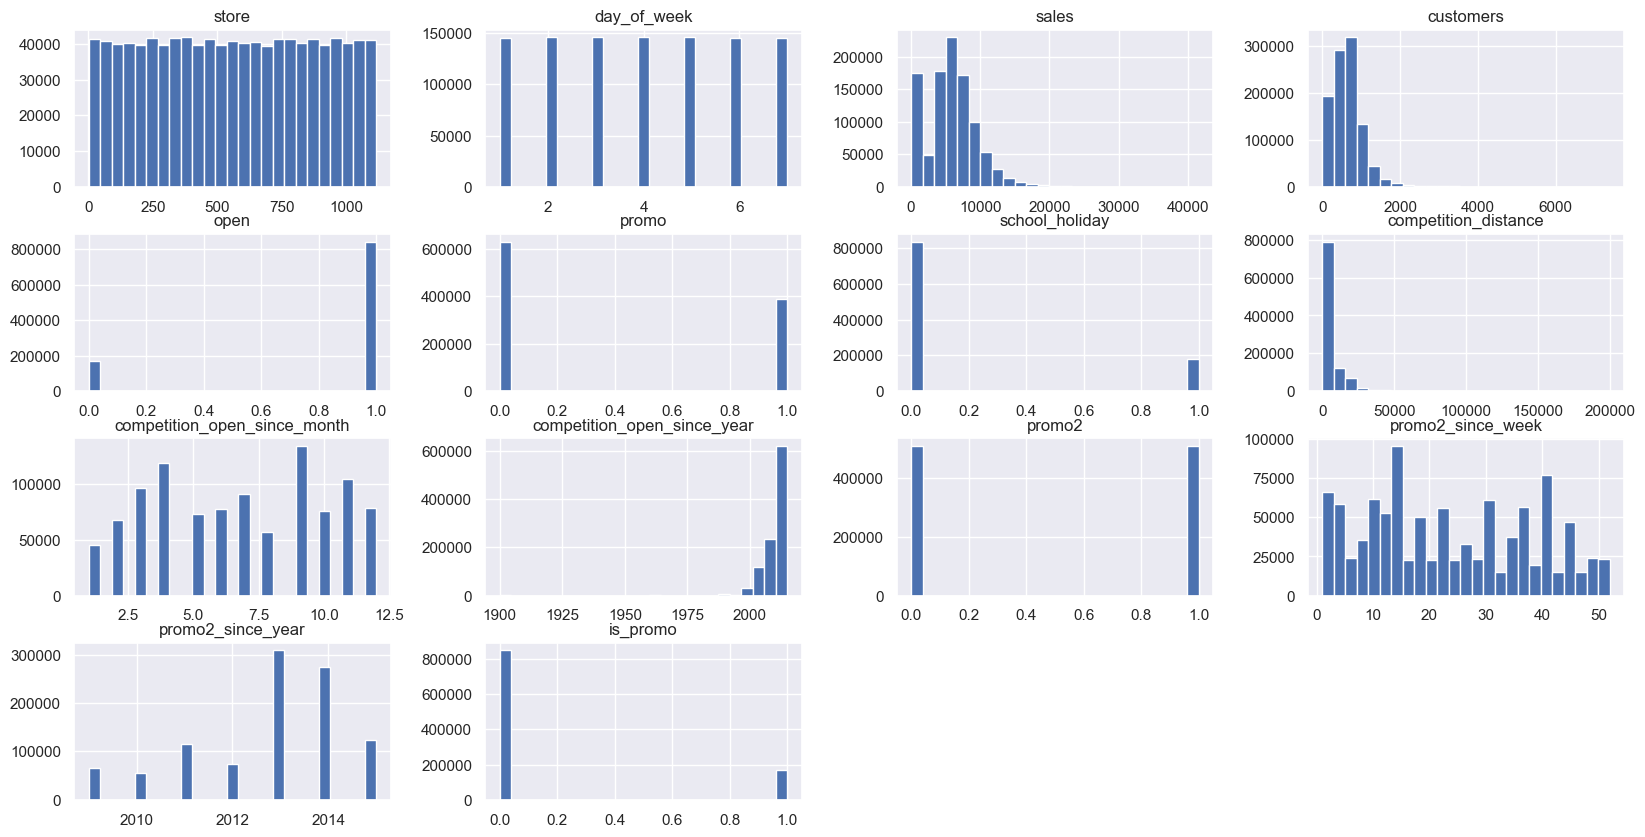

In [48]:
num_attributes.hist(bins=25, figsize=(20,10));

### 4.1.3 Categorical Variable 

In [49]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


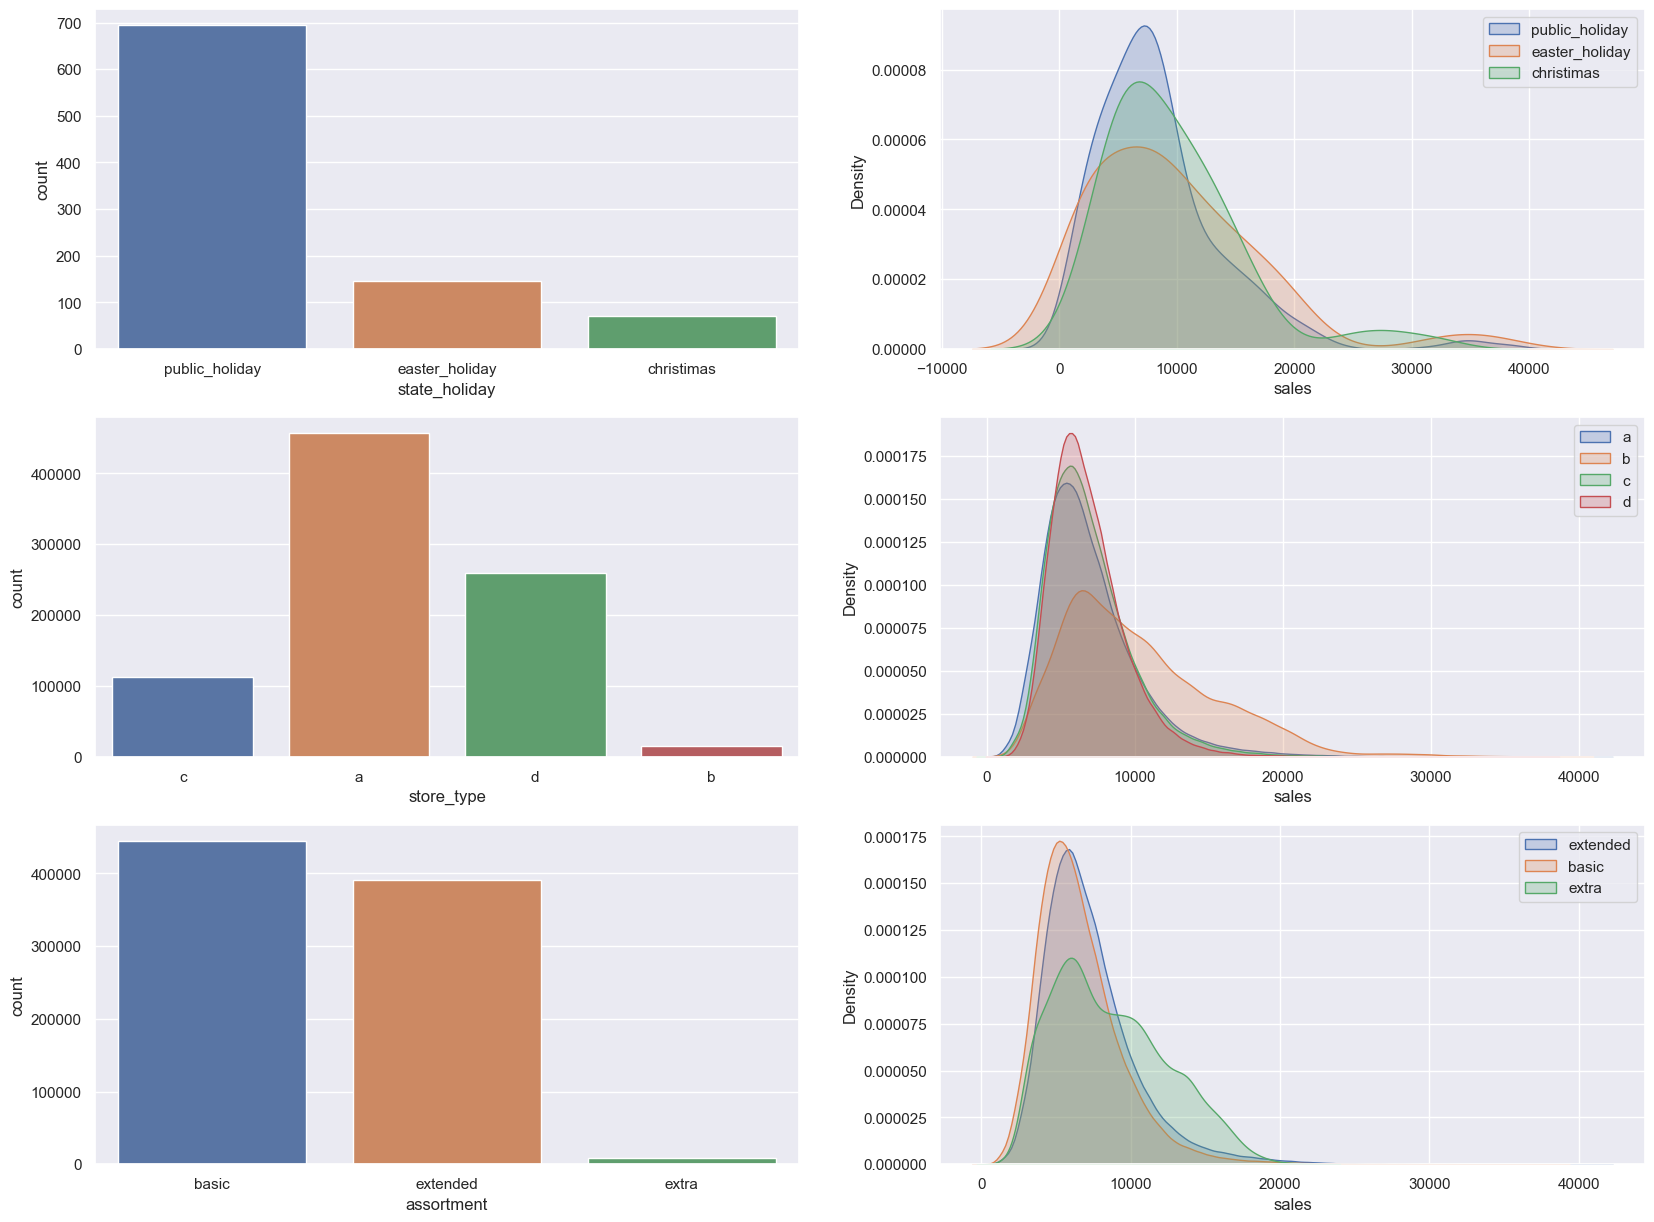

In [50]:
#state_holiday
plt.figure(figsize=(20,15))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a, x='state_holiday');

plt.subplot(3, 2, 2)
# sns.kdeplot(a, x='sales', hue='state_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'], x='sales', fill=True, label='public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'], x='sales', fill=True, label='easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christimas'], x='sales', fill=True, label='christimas')
plt.ticklabel_format(style='plain', axis='y') #remove notacao cientifica
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4, x='store_type');

plt.subplot(3, 2, 4)
# sns.kdeplot(df4, x='sales', hue='store_type', hue_order=['a','b', 'c', 'd'],fill=True);
sns.kdeplot(df4[df4['store_type'] == 'a'], x='sales', fill=True, label='a')
sns.kdeplot(df4[df4['store_type'] == 'b'], x='sales', fill=True, label='b')
sns.kdeplot(df4[df4['store_type'] == 'c'], x='sales', fill=True, label='c')
sns.kdeplot(df4[df4['store_type'] == 'd'], x='sales', fill=True, label='d')
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4, x='assortment');

plt.subplot(3, 2, 6)
# sns.kdeplot(df4, x='sales', hue='assortment',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended'], x='sales', fill=True, label='extended')
sns.kdeplot(df4[df4['assortment'] == 'basic'], x='sales', fill=True, label='basic')
sns.kdeplot(df4[df4['assortment'] == 'extra'], x='sales', fill=True, label='extra')
plt.legend()

plt.show();


## 4.2 Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FAlSO** Lojas com assortment maior vendem menos 

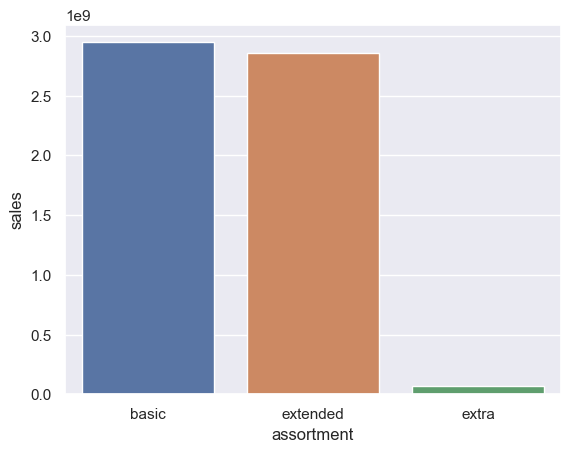

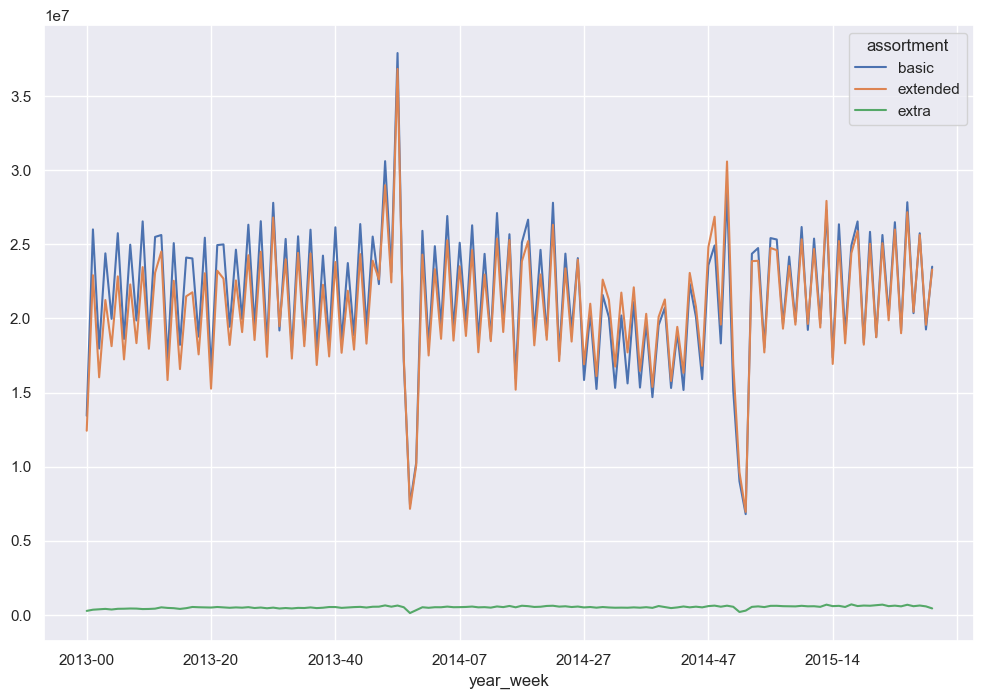

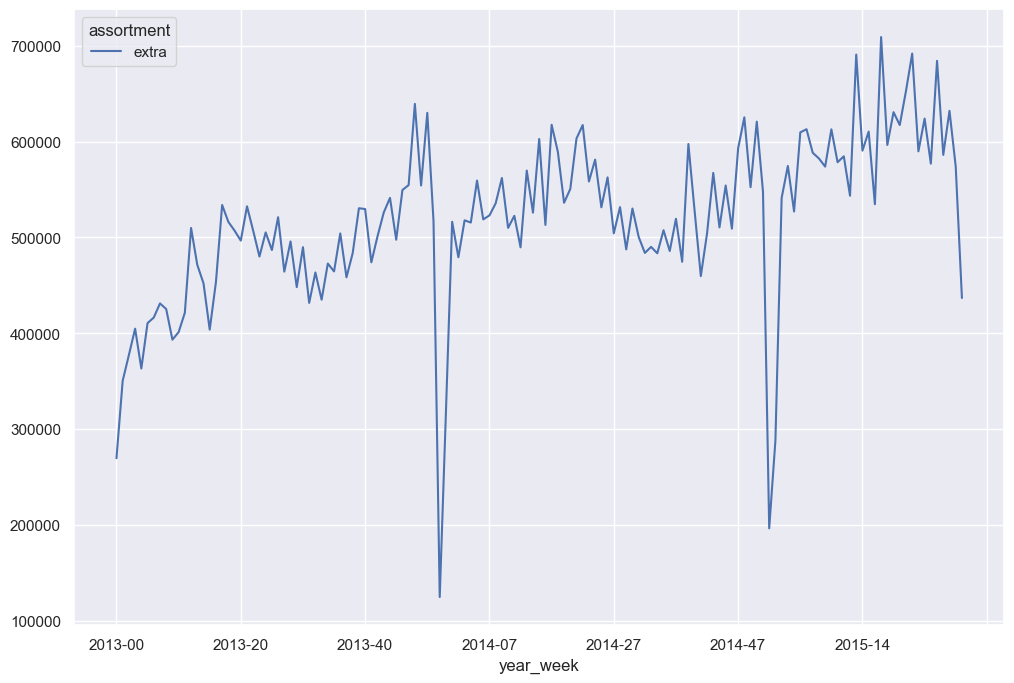

In [51]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(aux1, x='assortment', y='sales')

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot(figsize=(12,8))

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot(figsize=(12,8));

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSE** Lojas com competidores próximos vendem mais

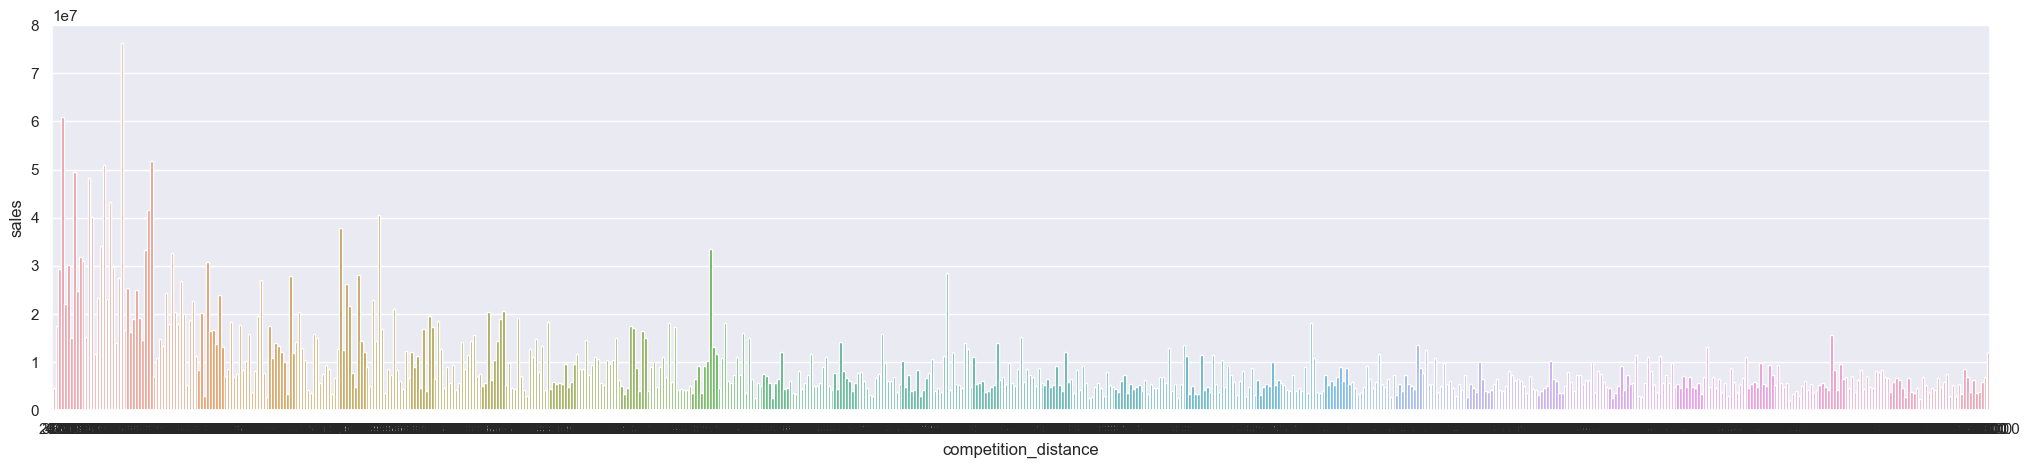

In [52]:
#figura muito granular

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(25,5))
sns.barplot(aux1,x='competition_distance',y='sales');

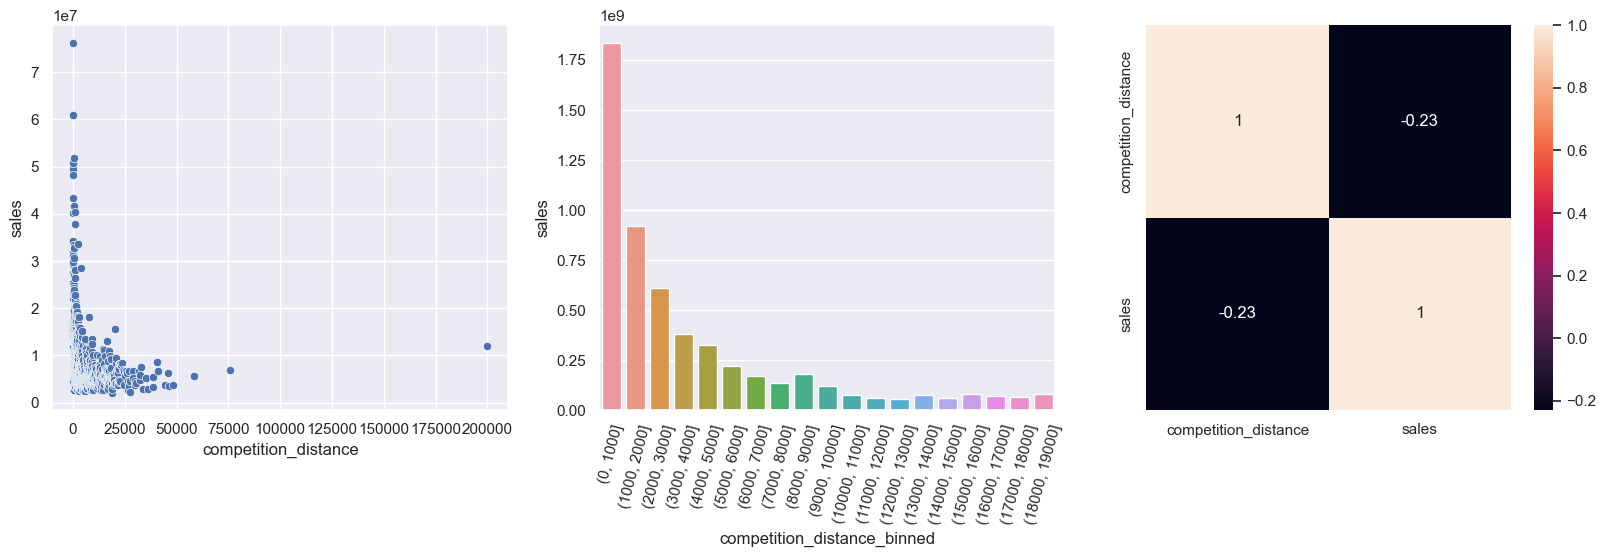

In [53]:
bins = list(np.arange(0,20000,1000))
aux1 = df4.copy()
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
aux2 = aux1[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(aux2, x='competition_distance', y='sales')

plt.subplot(1,3,2)
aux3 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(aux3, x='competition_distance_binned',y='sales')
plt.xticks(rotation=75)

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** Competição mais recente está relacionada com maiores vendas

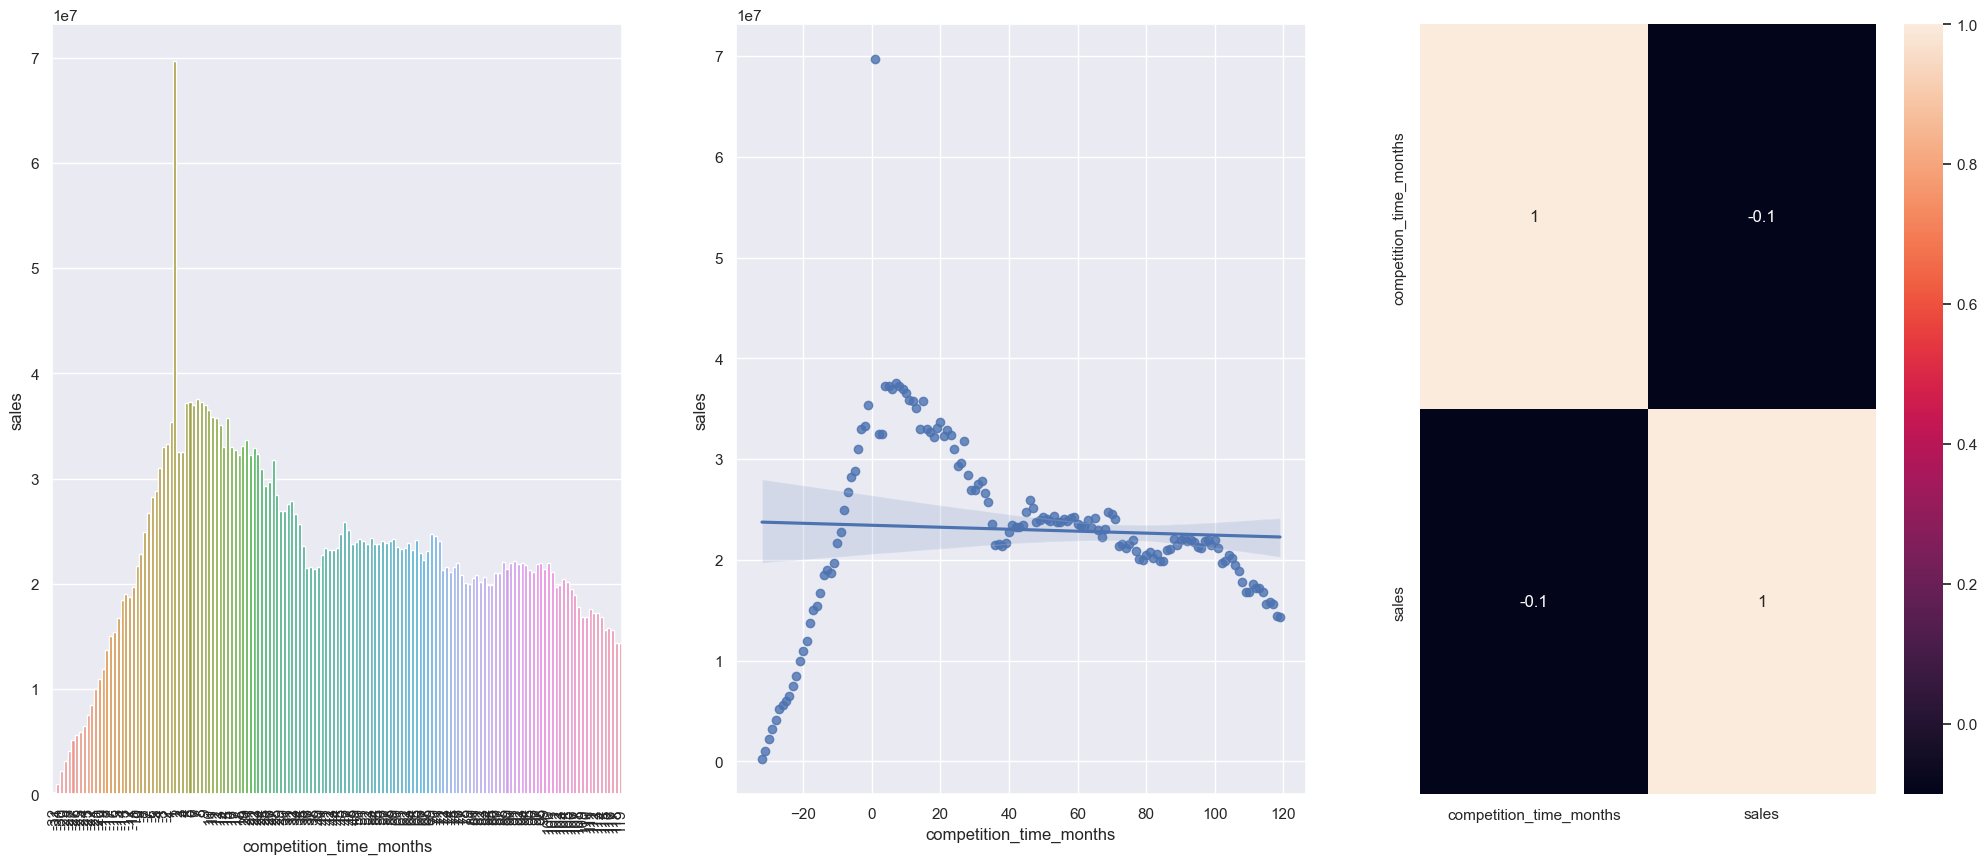

In [54]:
plt.figure(figsize=(25,10))

plt.subplot(1,3,1)
aux1 = df4[['competition_time_months', 'sales']].groupby('competition_time_months').sum().reset_index()
aux2 = aux1[(aux1['competition_time_months'] < 120) & (aux1['competition_time_months']!=0)]
sns.barplot(aux2, x='competition_time_months', y='sales')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(aux2, x='competition_time_months', y='sales'); # esse gráfico é apenas para demonstração e não tem significado muito forte

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);
#valores negativos indicam daqui quanto tempo abrirá um competidor

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Durante um período de tempo mais longo de promoção, as lojas passam a vender menos

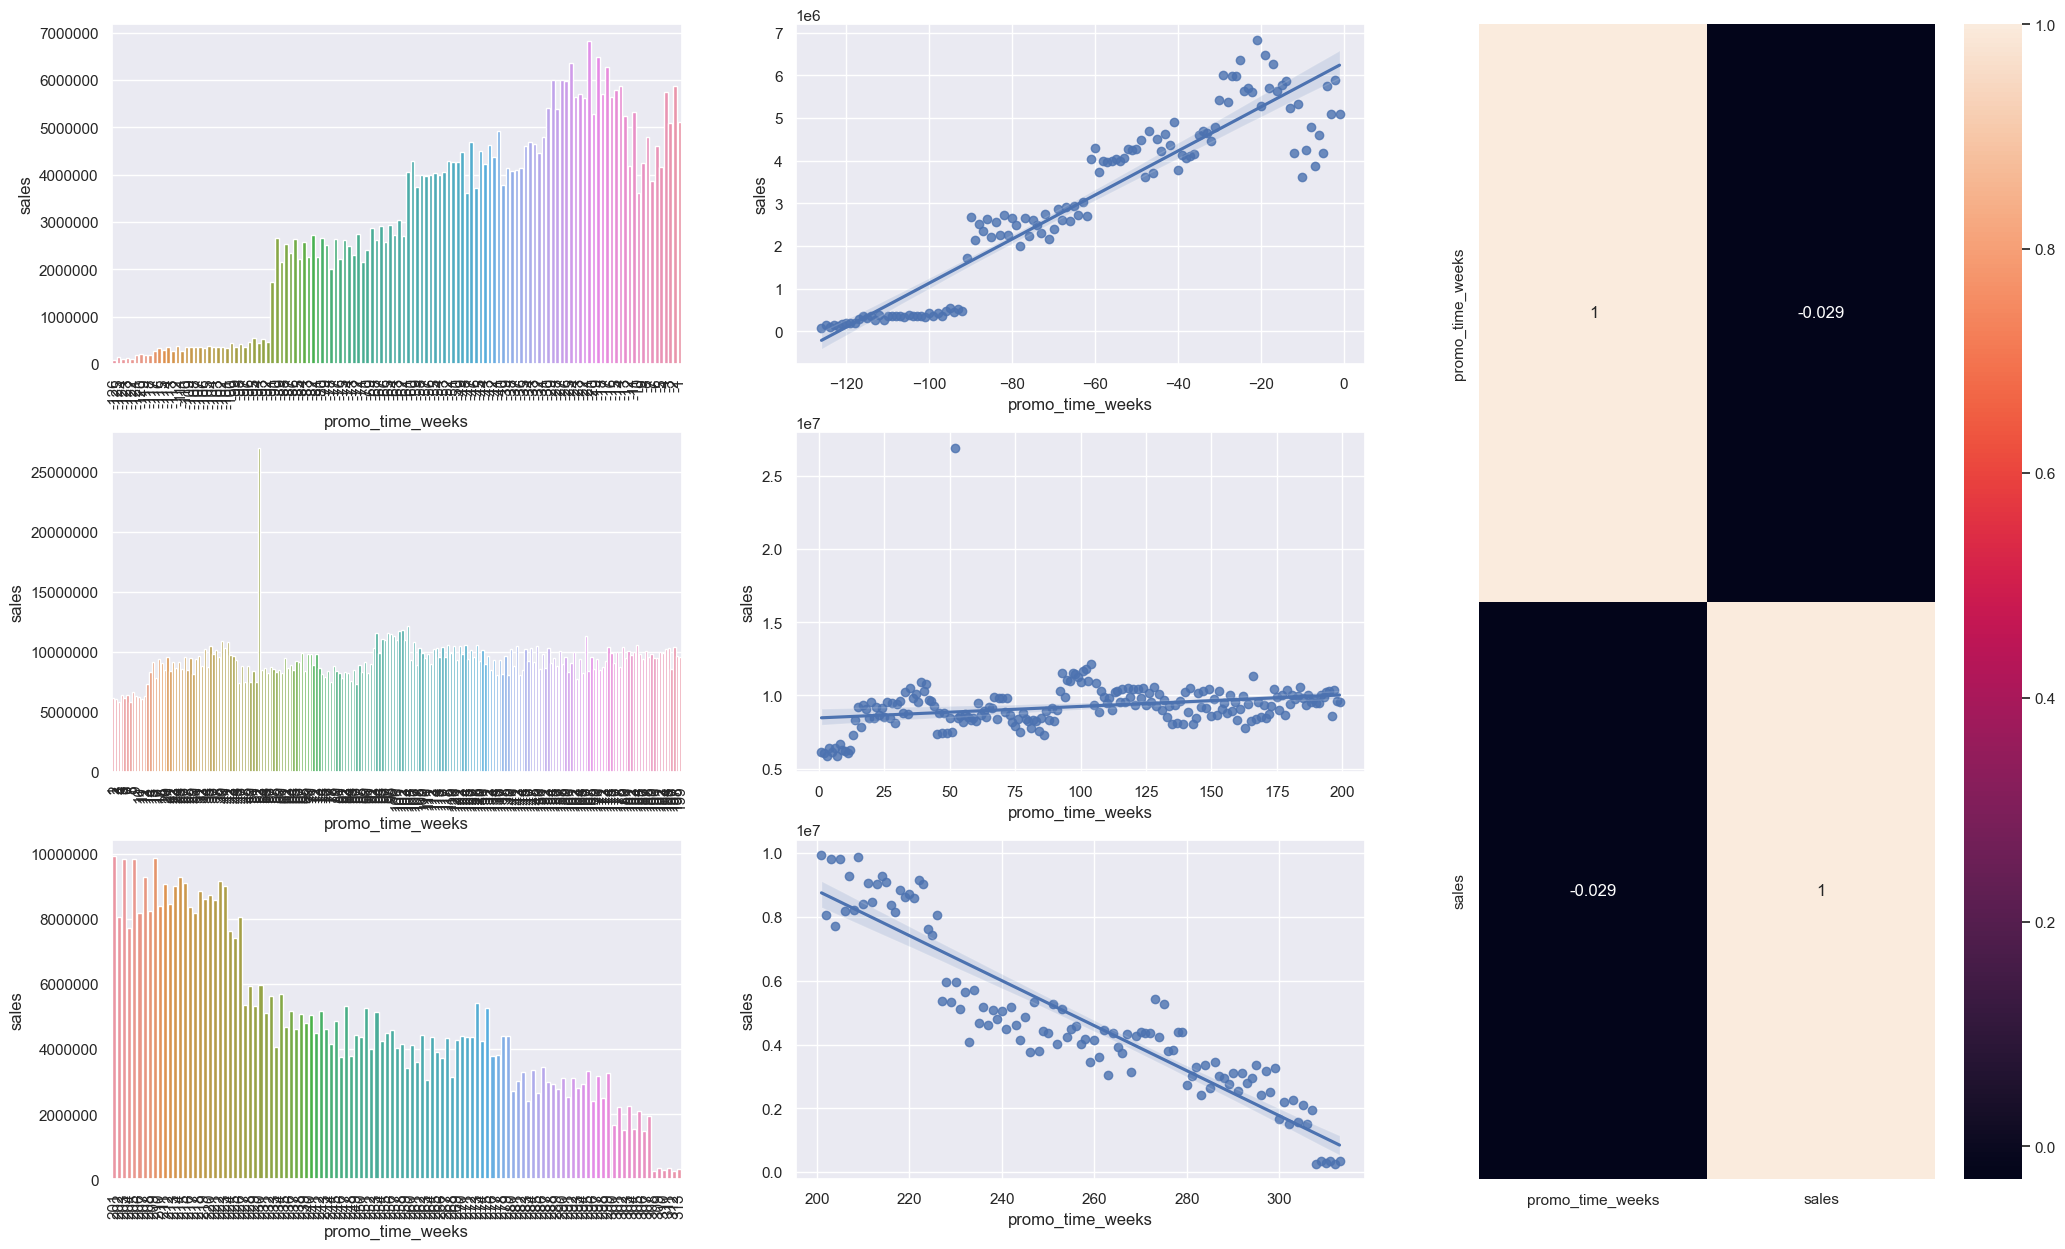

In [55]:
#promo_time_weeks < 0 -> periodo de promocao regular
#promo_time_weeks > 0 -> periodo de promocao estendido

# plt.figure(figsize=(25,15))
aux1 = df4[['promo_time_weeks','sales']].groupby('promo_time_weeks').sum().reset_index()

grid = GridSpec(3, 3)

plt.figure(figsize=(25,15))
plt.subplot(grid[0,0])
promo_regular = aux1[aux1['promo_time_weeks'] < 0]
sns.barplot(promo_regular, x='promo_time_weeks', y='sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(promo_regular, x='promo_time_weeks', y='sales')

plt.subplot(grid[1,0])
promo_extended = aux1[(aux1['promo_time_weeks'] > 0) & (aux1['promo_time_weeks'] < 200)]
sns.barplot(promo_extended, x='promo_time_weeks', y='sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(promo_extended, x='promo_time_weeks', y='sales')

plt.subplot(grid[2,0])
promo_extended = aux1[aux1['promo_time_weeks'] > 200]
sns.barplot(promo_extended, x='promo_time_weeks', y='sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.subplot(grid[2,1])
sns.regplot(promo_extended, x='promo_time_weeks', y='sales')

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### **H5.** Lojas com mais dias de promoção deveriam vender mais.

In [56]:
#validar para dias é semelhante

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** Lojas que participaram apenas da promocao tradicional venderam mais

In [57]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


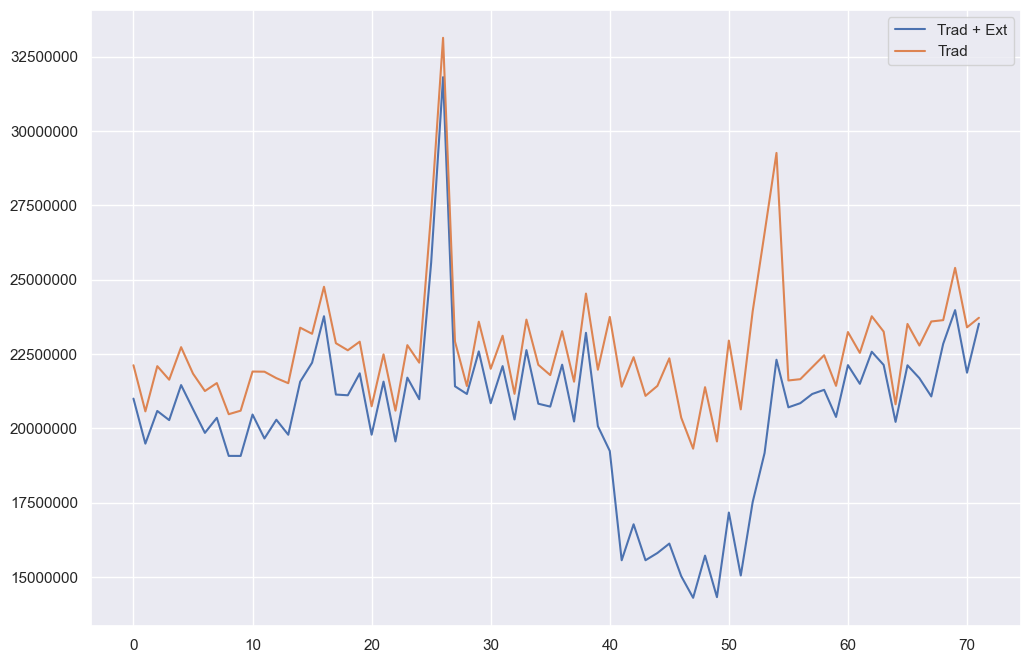

In [58]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux = aux1.plot()
# plt.ticklabel_format(style='plain', axis='y')

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=aux, figsize=(12,8))
plt.ticklabel_format(style='plain', axis='y')
aux.legend(labels=['Trad + Ext', 'Trad']);

### **H7.** Lojas aertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas vendem menos no feriadod e Natal. obs. o ano de 2015 não estava fechado

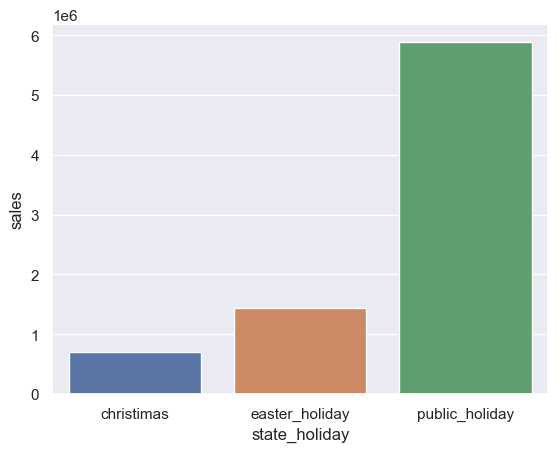

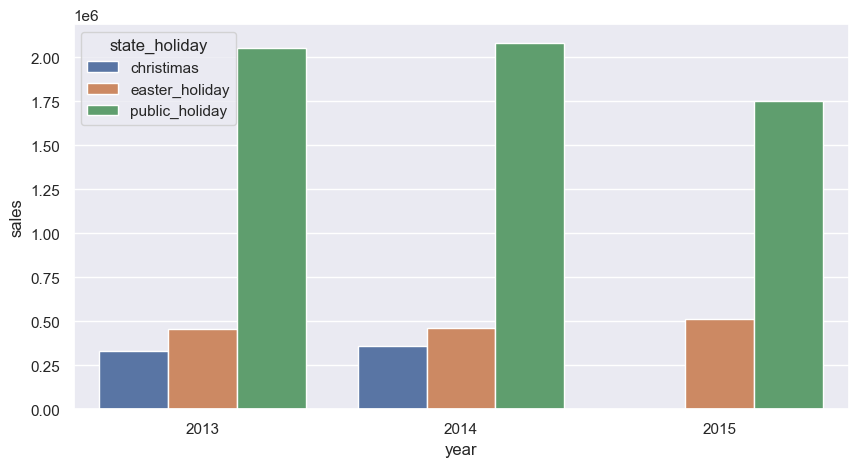

In [59]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

sns.barplot(aux1, x='state_holiday', y='sales')

aux2 = aux[['year','state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(aux2, x='year', y= 'sales', hue='state_holiday');

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** lojas estavam vendendo menos ao longo dos anos.

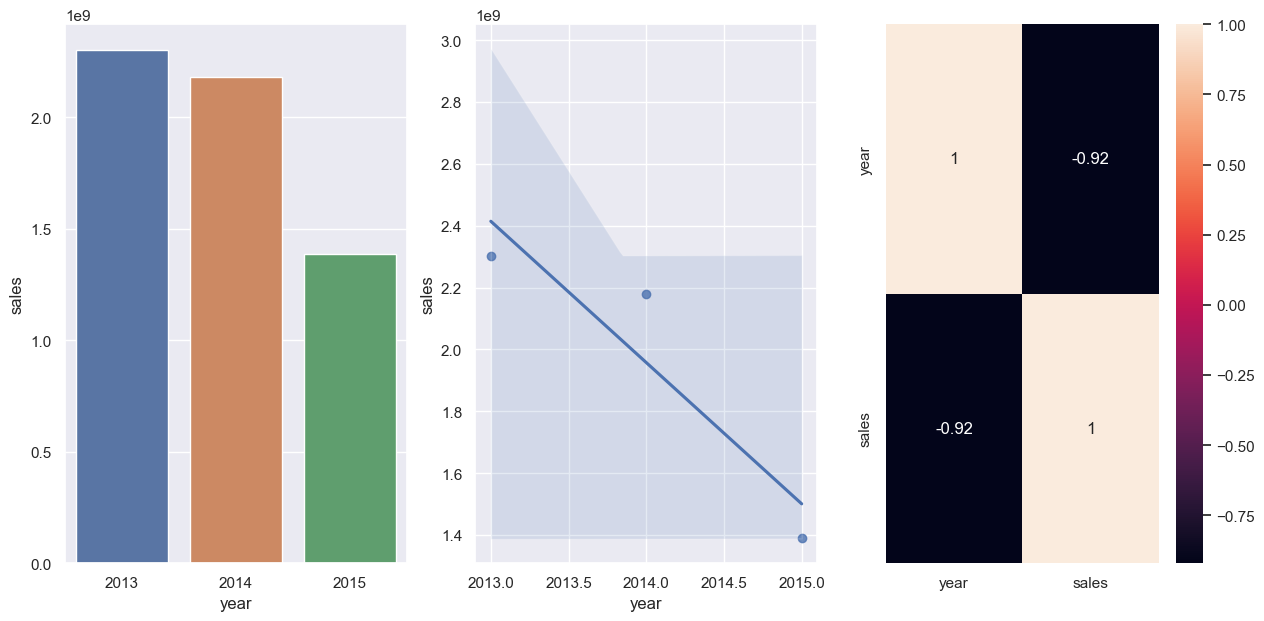

In [60]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(aux1, x='year', y='sales')

plt.subplot(1,3,2)
sns.regplot(aux1, x='year', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre do ano

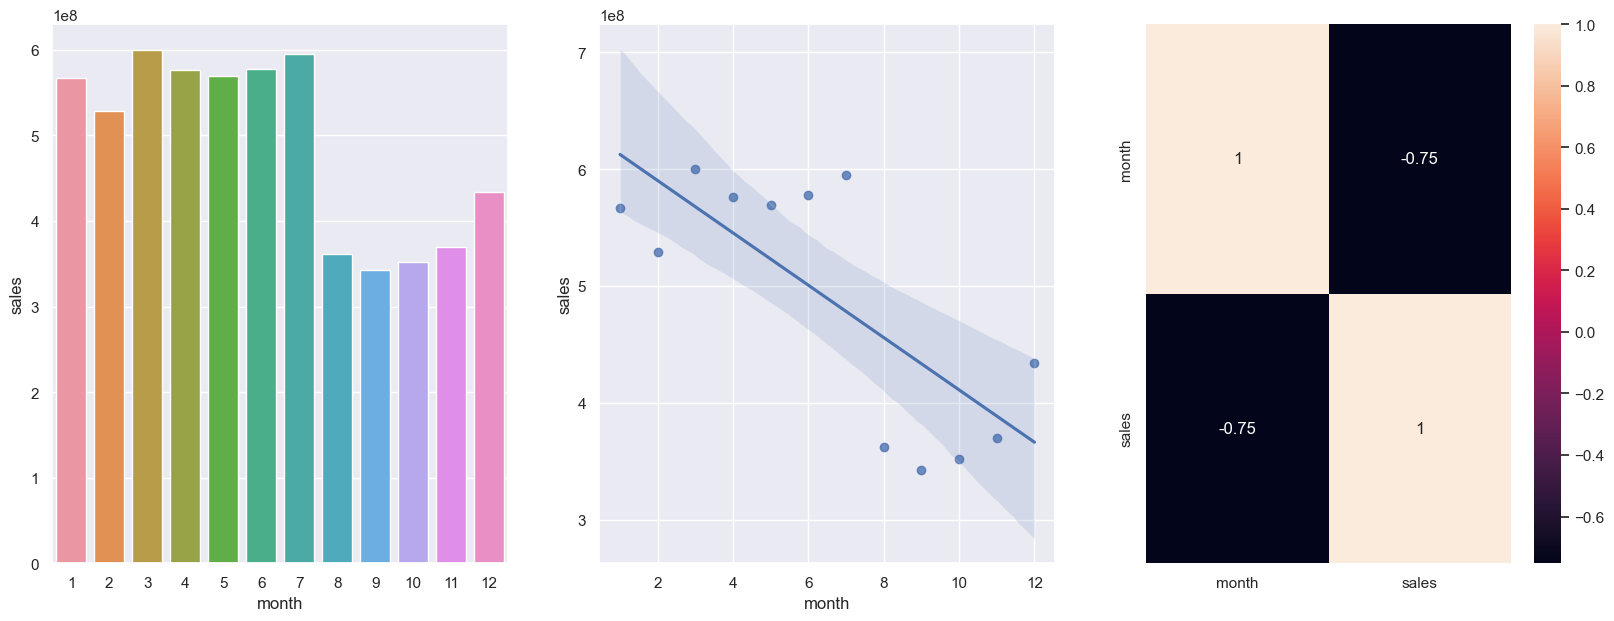

In [61]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.barplot(aux1, x='month', y='sales')

plt.subplot(1,3,2)
sns.regplot(aux1, x='month', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** Por mais que o recebimento de salário seja um fator, as pessoas compram menos nos primeiros 10 dias do mes

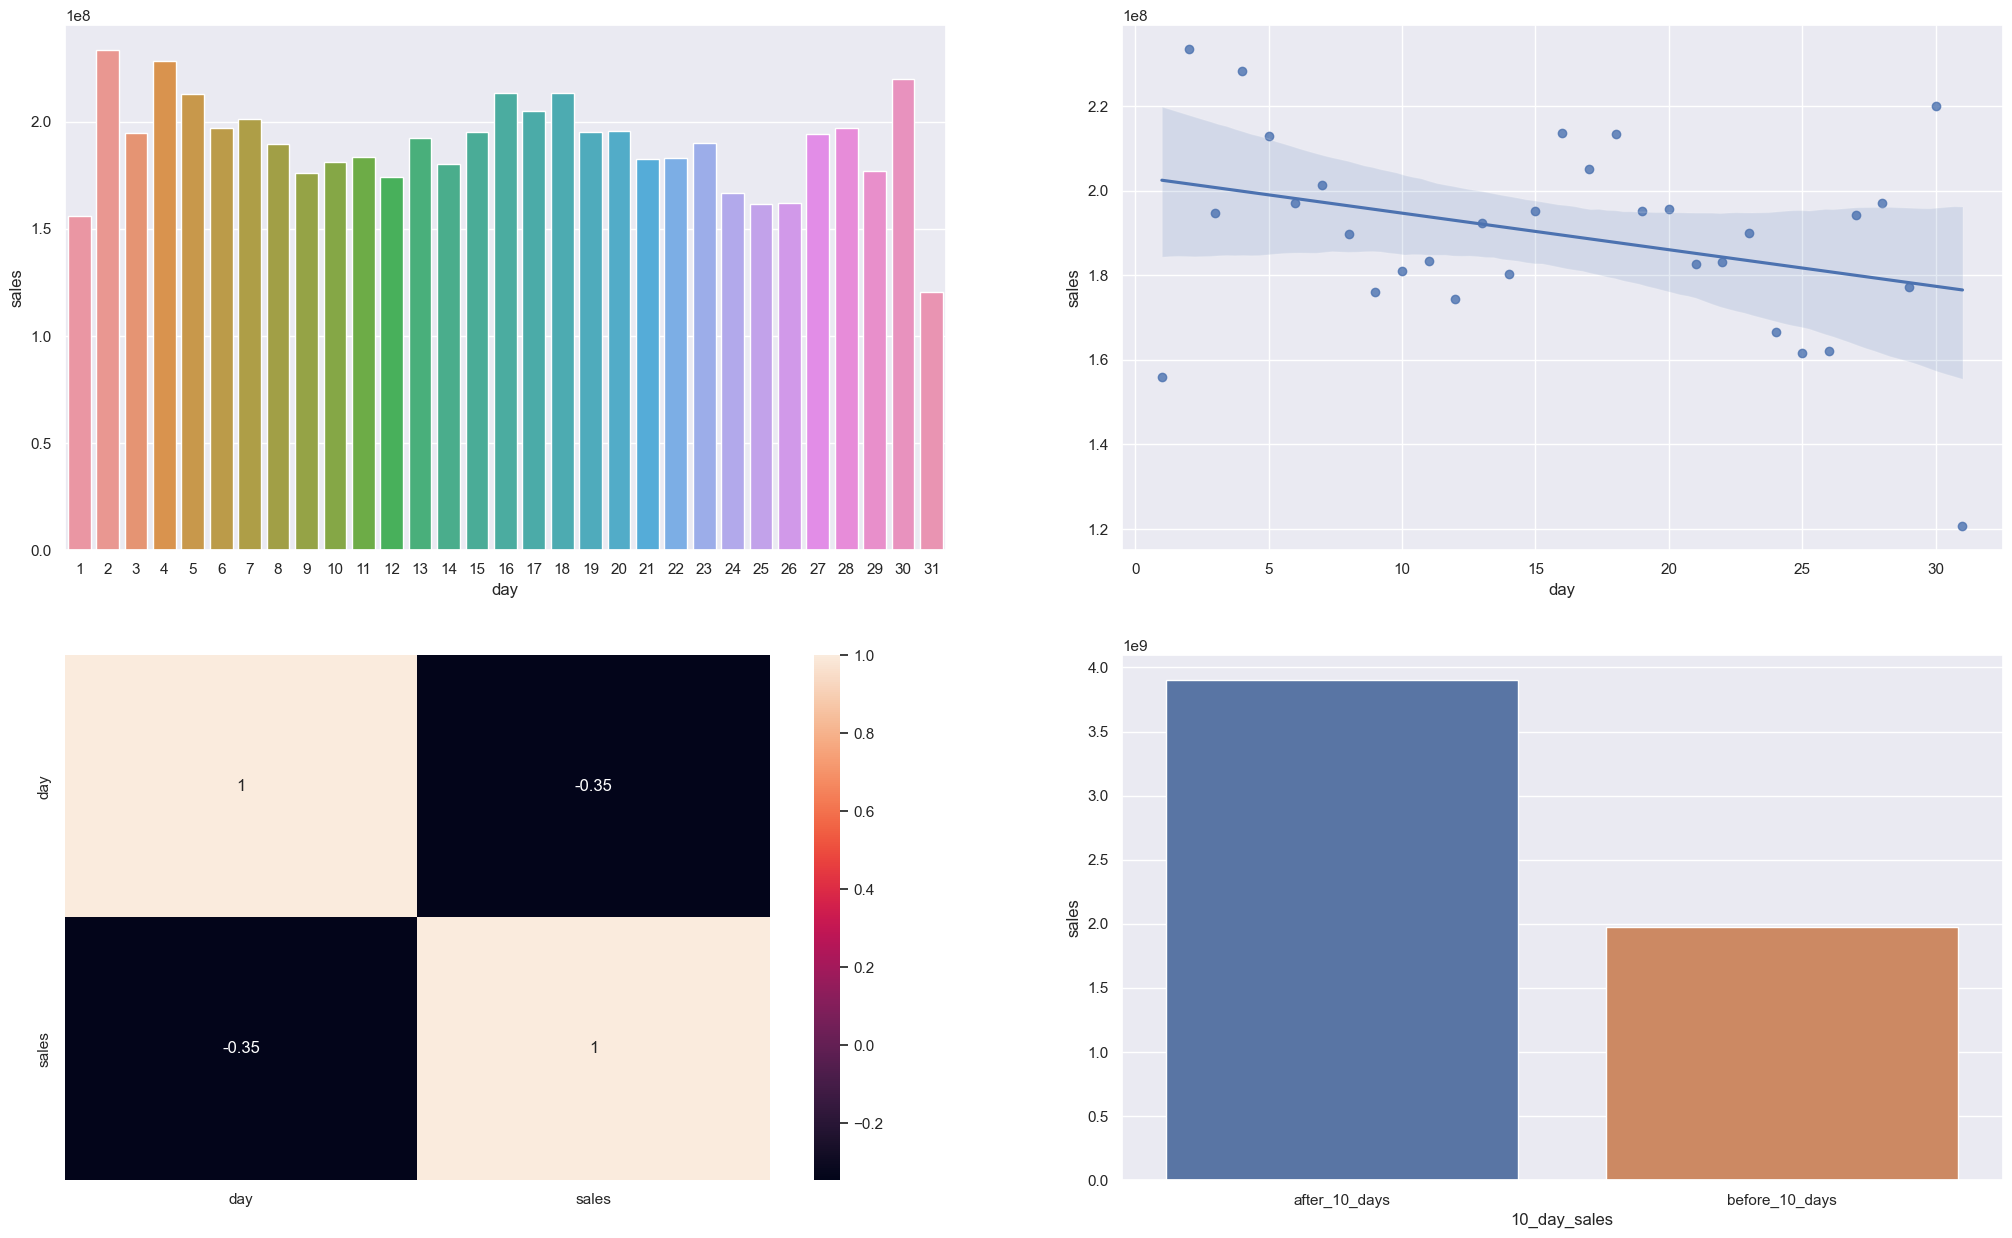

In [62]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
sns.barplot(aux1, x='day', y='sales')

plt.subplot(2,2,2)
sns.regplot(aux1, x='day', y='sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['10_day_sales'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['10_day_sales', 'sales']].groupby('10_day_sales').sum().reset_index()
sns.barplot(aux2, x='10_day_sales', y='sales');

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** Lojas vendem menos nos finais de semana 

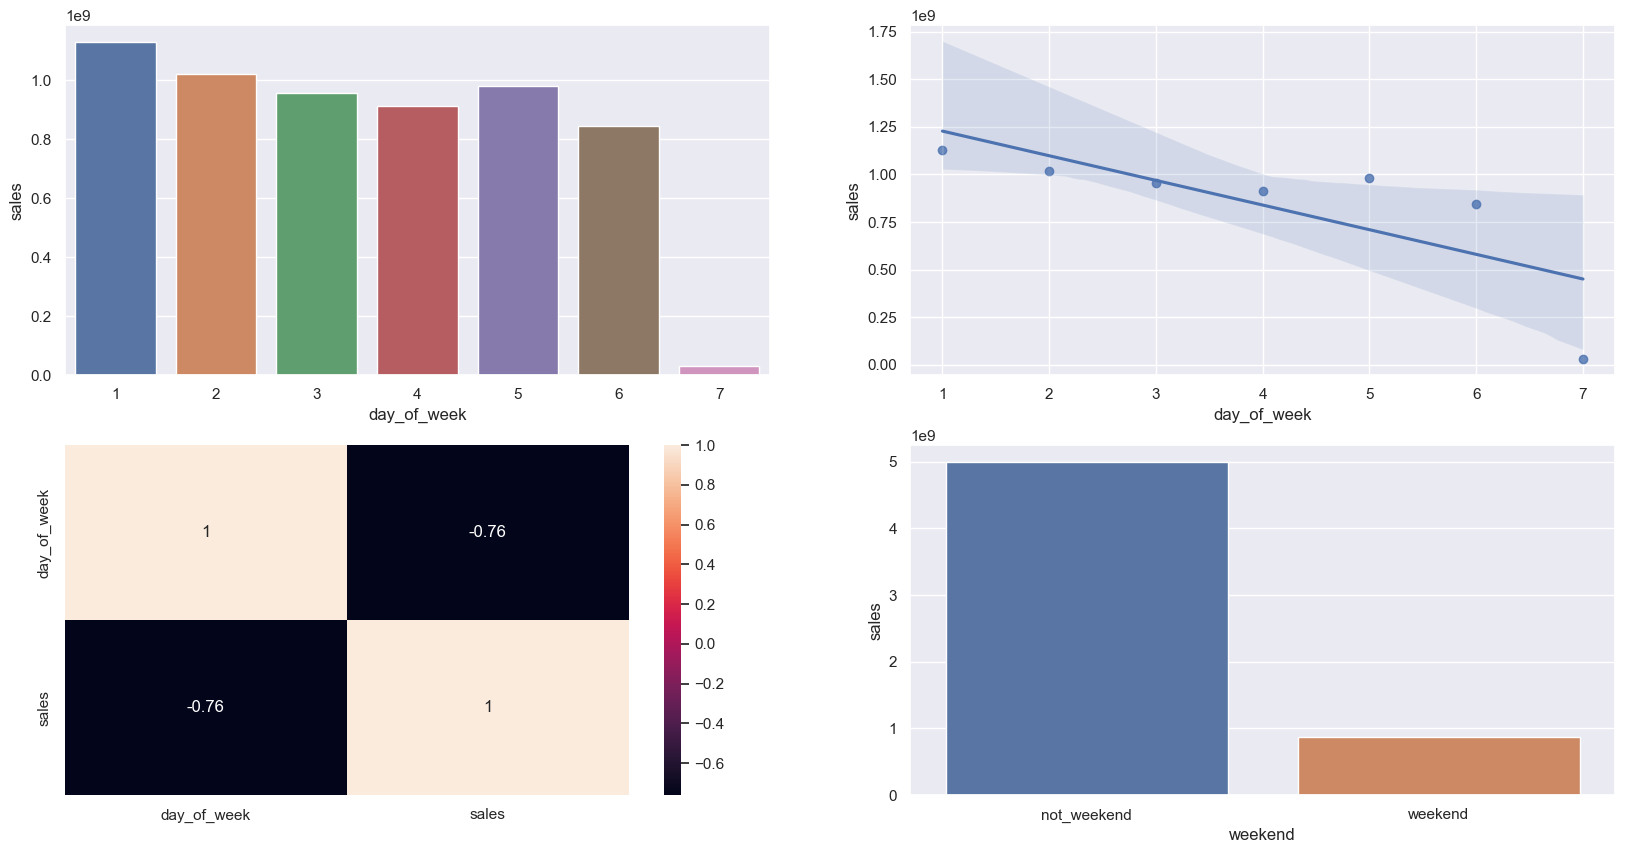

In [63]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(aux1, x='day_of_week', y='sales')

plt.subplot(2,2,2)
sns.regplot(aux1, x='day_of_week', y='sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['weekend'] = aux1['day_of_week'].apply(lambda x: 'weekend' if ((x==6) | (x==7)) else 'not_weekend')
aux2 = aux1[['weekend', 'sales']].groupby('weekend').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(aux2, x='weekend', y='sales');

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** Lojas vendem menos durante os feriados escolares. No entanto, nos meses de Julho/Agosto (provavelmente ferias de verão), há uma inversão no comportamento

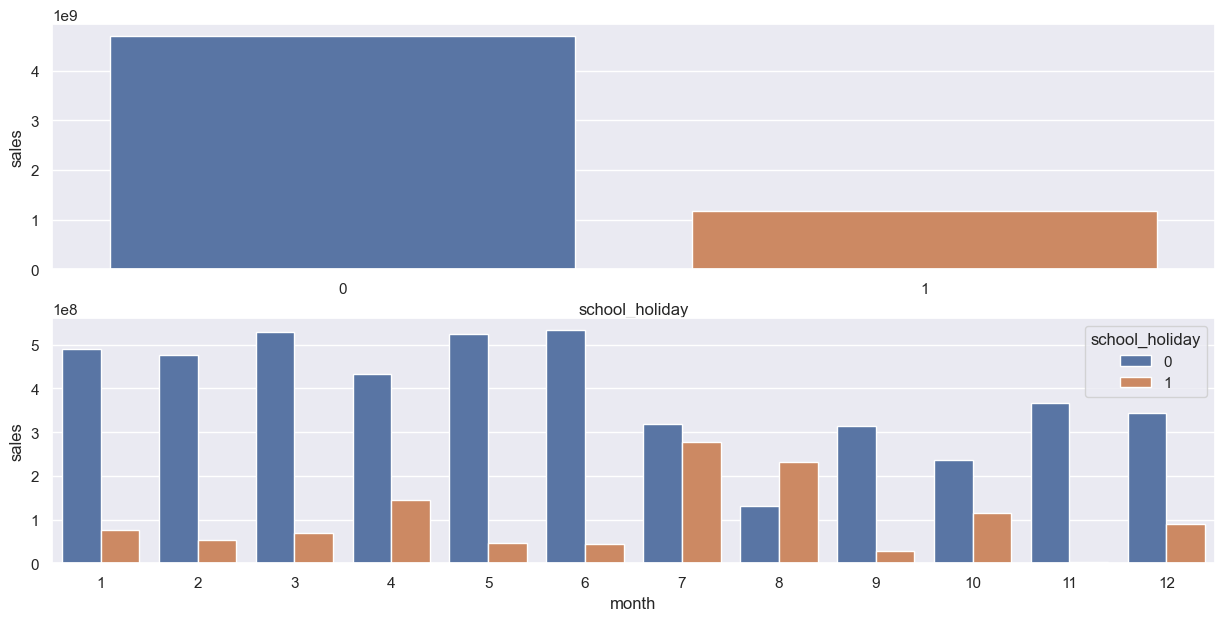

In [64]:
plt.figure(figsize=(15,7))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(aux1, x='school_holiday', y='sales')

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(aux2, x='month', y='sales', hue='school_holiday');

## 4.3 Multivariate Analysis

### 4.3.1 Numeric Attributes

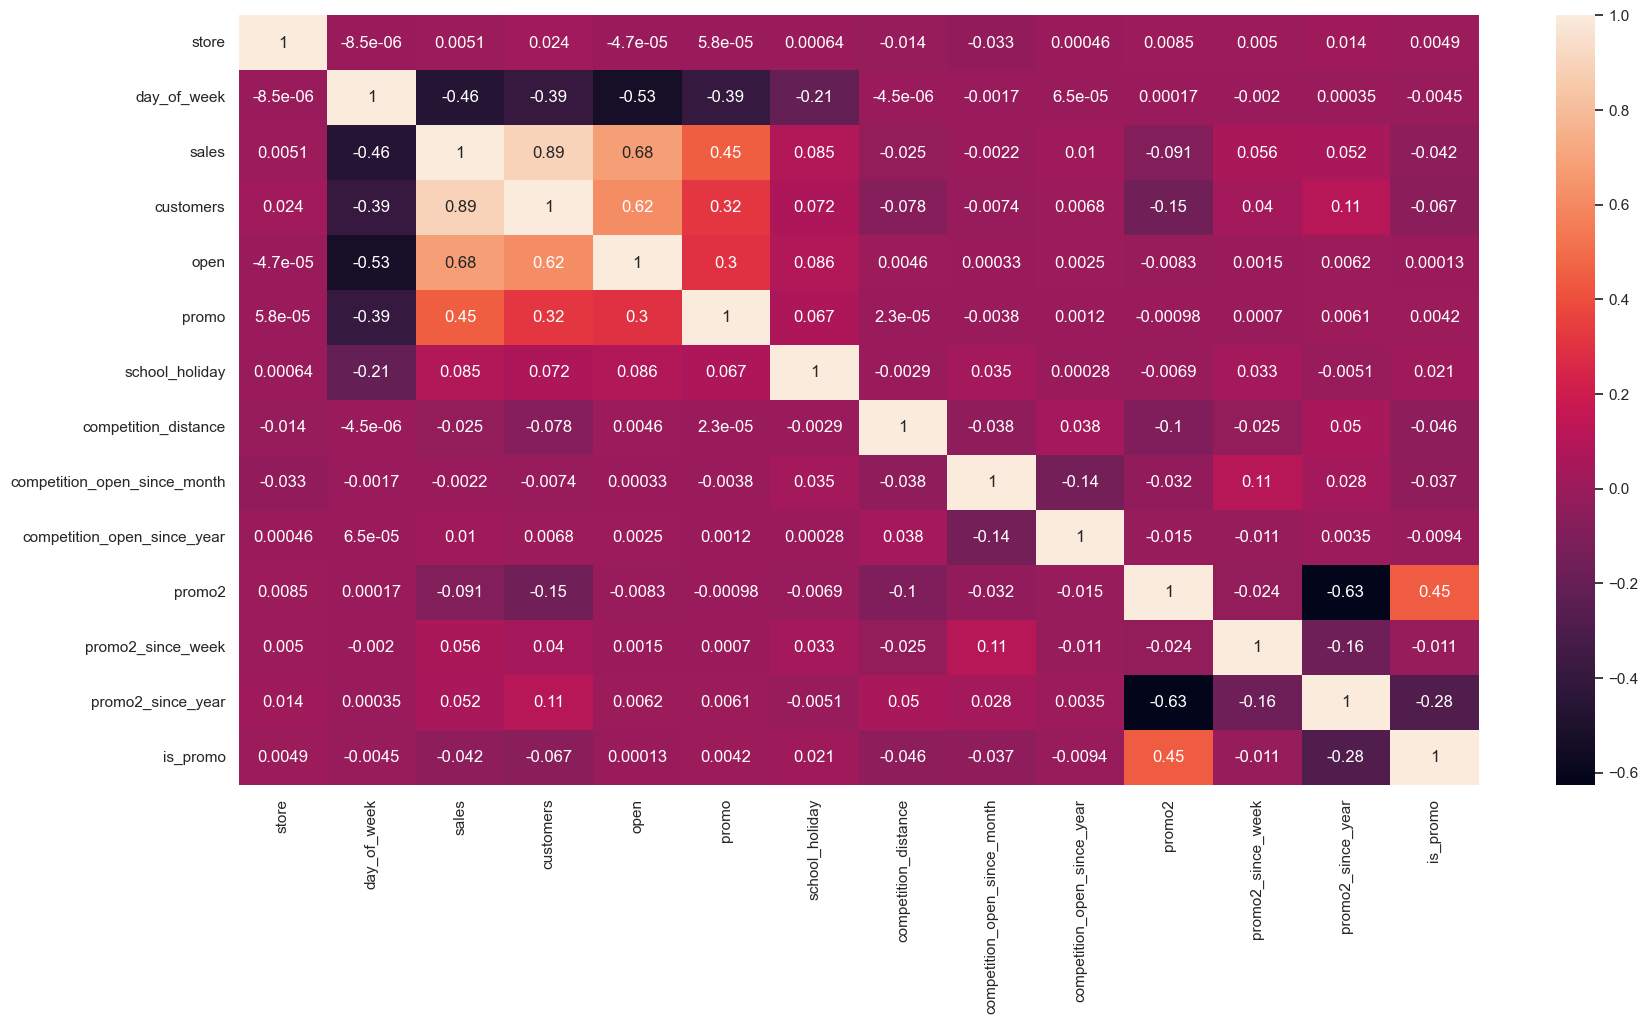

In [65]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [66]:
#Cramer's V - valores de 0 a 1 enquanto pearson vai de -1 a 1 - aplicar Bias correction
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr= max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))
    

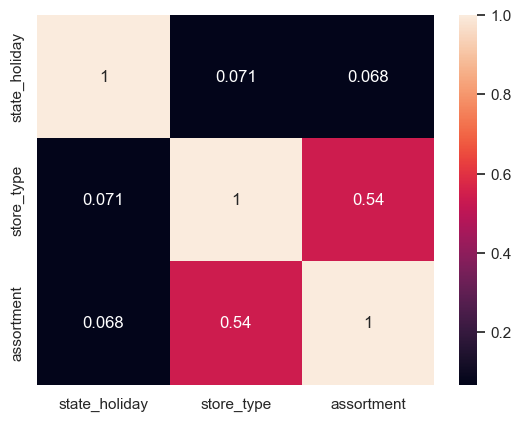

In [67]:
#selecting categorical data
categorical = df4.select_dtypes(include='object')

#calculating cramer's v
a1 = cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2 = cramer_v(categorical['state_holiday'], categorical['store_type'])
a3 = cramer_v(categorical['state_holiday'], categorical['assortment'])

a4 = cramer_v(categorical['store_type'], categorical['state_holiday'])
a5 = cramer_v(categorical['store_type'], categorical['store_type'])
a6 = cramer_v(categorical['store_type'], categorical['assortment'])

a7 = cramer_v(categorical['assortment'], categorical['state_holiday'])
a8 = cramer_v(categorical['assortment'], categorical['store_type'])
a9 = cramer_v(categorical['assortment'], categorical['assortment'])

d = pd.DataFrame({'state_holiday' : [a1,a2,a3],
                  'store_type' : [a4,a5,a6],
                  'assortment' : [a7,a8,a9] 
                })
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5.0 Processing Data

In [68]:
df5 = df4.copy()

## 5.1 Normalizing 

In [69]:
#check section 4.1.2 for numeric variables that follow normal distribution (none of them).

## 5.2 Rescaling 

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) #aplica a formula do robust scaler

#competition time month
df5['competition_time_months'] = rs.fit_transform(df5[['competition_time_months']].values)

#promo time week - não apresenta outliers relevantes
df5['promo_time_weeks'] = mms.fit_transform(df5[['promo_time_weeks']].values) #aplica o Min-Max Scaler

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Data Processing

### 5.3.1 Encoding

In [72]:
#state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assort = list(df5['assortment'].drop_duplicates())
assort[1], assort[2] = assort[2], assort[1]
assortment_dict = {}
for k in range(3):
    assortment_dict[assort[k]] = k+1
df5['assortment'] = df5['assortment'].map(assortment_dict)